In [59]:
import cv2
import numpy as np
from IPython import get_ipython
import matplotlib.pyplot as plt
import os
import random
import gc
import seaborn as sns
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
Epocas = 50
TotalTreino = 100
#Numero de colunas a serem exibidas as imagens
columns = 3

In [60]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
train_dir = "/content/drive/MyDrive/tcc/arquivos/train"

In [5]:
train_img = []
for train in os.listdir(train_dir):
  train_muda = [train_dir+"/"+train+"/"+img for img in os.listdir(train_dir+"/"+train)]
  train_img += train_muda[:TotalTreino]

In [6]:
print(len(train_img))

300


In [7]:
random.shuffle(train_img)

In [126]:
nrows = 180
ncolumns = 120
channels = 3  #change to 1 if you want to use grayscale image

In [9]:
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels

        if 'CARAIBA' in image:
            y.append(0)
        elif 'GUARITA' in image:
            y.append(1)
        elif 'IPE_AMARELO' in image:
            y.append(2)
        

    return X, y

In [10]:
X, y = read_and_process_image(train_img)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rótulos para mudas:')

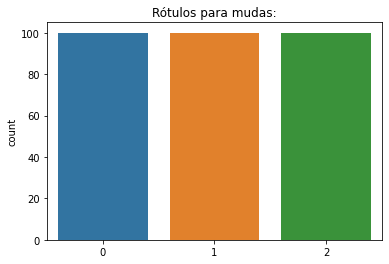

In [11]:
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Rótulos para mudas:')

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (240, 120, 180, 3)
Shape of validation images is: (60, 120, 180, 3)
Shape of labels is: (240,)
Shape of labels is: (60,)


In [13]:
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 16

print(ntrain, nval)

240 60


In [19]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential

num_classes = 3
#layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3),  activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3),  activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#Lets see our model
model.summary()
#softmax

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 178, 118, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 59, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 28, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 41, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 13, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 11, 128)      

In [16]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale


#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [17]:
print("Train Generator", len(train_generator))
print("Val Generator", len(val_generator))

Train Generator 15
Val Generator 4


In [115]:
#100 steps per epoch
Epocas = 50

history = model.fit_generator(train_generator, steps_per_epoch=ntrain // batch_size, epochs=Epocas, validation_data=val_generator, validation_steps=nval // batch_size)
model.save('modelo.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
15/15 [==============================] - 8s 120ms/step - loss: 0.0150 - accuracy: 0.9917 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 2/50
15/15 [==============================] - 1s 80ms/step - loss: 0.0410 - accuracy: 0.9833 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 3/50
15/15 [==============================] - 1s 79ms/step - loss: 0.0317 - accuracy: 0.9875 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/50
15/15 [==============================] - 1s 80ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.0341 - val_accuracy: 0.9792
Epoch 5/50
15/15 [==============================] - 1s 80ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/50
15/15 [==============================] - 1s 81ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.3725e-04 - val_accuracy: 1.0000
Epoch 7/50
15/15 [==============================] - 1s 80ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 8/

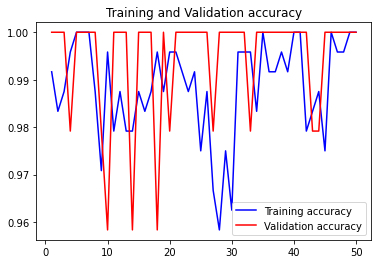

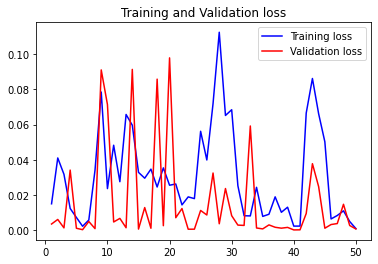

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


###Rodando Validação

In [159]:
from keras.models import load_model

In [160]:
model=load_model('modelo.h5')

In [161]:
teste_dir = "/content/drive/MyDrive/tcc/arquivos/test2"

In [162]:
os.listdir(teste_dir)

['IPE_AMARELO', 'GUARITA', 'CARAIBA']

In [163]:
teste_img = []
for teste in os.listdir(train_dir):
  train_muda = [teste_dir+"/"+teste+"/"+img for img in os.listdir(teste_dir+"/"+teste)]
  teste_img += train_muda

In [164]:
for img in teste_img:
  print(img)

/content/drive/MyDrive/tcc/arquivos/test2/CARAIBA/IMG_3758.JPG
/content/drive/MyDrive/tcc/arquivos/test2/CARAIBA/IMG_3757.JPG
/content/drive/MyDrive/tcc/arquivos/test2/CARAIBA/IMG_3682.JPG
/content/drive/MyDrive/tcc/arquivos/test2/CARAIBA/IMG_3664.JPG
/content/drive/MyDrive/tcc/arquivos/test2/CARAIBA/IMG_3686.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3755.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3432.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3754.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3466.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3473.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3464.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3468.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3465.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3472.JPG
/content/drive/MyDrive/tcc/arquivos/test2/IPE_AMARELO/IMG_3471.JPG
/content/drive/

In [172]:
ImagensParaAvaliar = len(teste_img)
X_test, y_test = read_and_process_image(teste_img) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)
text_labels = []

In [167]:
mudas = ['CARAIBA','GUARITA','IPE_AMARELO']

In [173]:
columns = 2
Ytest = np.array(y_test)
i=0
count=0
for batch in test_datagen.flow(x, batch_size=1):
    predictions = model.predict(batch,batch_size=16)
    pred = np.argmax(predictions, axis=1)
    print(pred[0]==Ytest[i])
    print('--------------------')
    i += 1
    if i % ImagensParaAvaliar == 0:
        break


False
--------------------
False
--------------------
True
--------------------
False
--------------------
False
--------------------
False
--------------------
True
--------------------
False
--------------------
True
--------------------
False
--------------------
False
--------------------
True
--------------------
False
--------------------
True
--------------------
False
--------------------
True
--------------------
True
--------------------
False
--------------------
False
--------------------
False
--------------------
False
--------------------
False
--------------------
True
--------------------
True
--------------------
